# DS1801 Project: Sentiment Analysis

## Part 1: Naive Bayes

In this notebook, you will learn how to use different packages in Python to build a complete pipeline for solving sentiment analysis problem. We will be using Mutinomial NB in this class.

### Pipeline

<img src="pipeline.png" width="800px">

### Get Familiar with dataset

In [3]:
import pandas as pd
import nltk
import string

In [4]:
# Load csv file into DataFrame
train = pd.read_csv('train.csv')

In [6]:
train.head()

,reviewText,sentiment
0,For a movie that gets no respect there sure ar...,pos
1,Bizarre horror movie filled with famous faces ...,pos
2,"A solid, if unremarkable film. Matthau, as Ein...",pos
3,It's a strange feeling to sit alone in a theat...,pos
4,"You probably all already know this by now, but...",pos


In [5]:
print("sentiment  :", train.sentiment[0])
print("reviewText :", train.reviewText[0])

sentiment  : pos
reviewText : For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.


In [7]:
train.shape

(25000, 2)

In [8]:
# Get a sample (head) of the data frame
train.head()

,reviewText,sentiment
0,For a movie that gets no respect there sure ar...,pos
1,Bizarre horror movie filled with famous faces ...,pos
2,"A solid, if unremarkable film. Matthau, as Ein...",pos
3,It's a strange feeling to sit alone in a theat...,pos
4,"You probably all already know this by now, but...",pos


In [9]:
# Statics on tags
train.sentiment.value_counts()

neg    12500
pos    12500
Name: sentiment, dtype: int64

See [Pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/10min.html?highlight=data%20frame) for more details.

### Load Data

In [10]:
def load_data(path):
    data = pd.read_csv(path)
    x = data['reviewText'].tolist()
    y = data['sentiment'].tolist()
    return x, y

In [11]:
train_x, train_y = load_data('train.csv')
test_x, test_y = load_data('test.csv')

In [12]:
print('training size:', len(train_x))
print('test size:', len(test_x))

training size: 25000
test size: 25000


### Preprocessing

In [14]:
nltk.download('stopwords')

lemmatizer = nltk.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
transtbl = str.maketrans(string.punctuation, ' ' * len(string.punctuation)) # Remove punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yurungu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [16]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
'ababc'.translate(str.maketrans('abc','def'))

'dedef'

In [18]:
def preprocessing(line):
    line = line.replace('<br />', '')   # Remove html tag (<br />)
    line = line.translate(transtbl)     # Remove punctuation
    
    # Get tokens
    tokens = []
    for t in nltk.word_tokenize(line):
        t = t.lower()
        if t not in stopwords:
            lemma = lemmatizer.lemmatize(t, 'v')
            tokens.append(lemma)
            
    return ' '.join(tokens)

In [19]:
# Yet a more compact way to write the code
def preprocessing(line: str) -> str:
    line = line.replace('<br />', '').translate(transtbl)
    
    tokens = [lemmatizer.lemmatize(t.lower(),'v')  # What to put in the list
              for t in nltk.word_tokenize(line)    # Where 
              if t.lower() not in stopwords]       # If
    
    return ' '.join(tokens)

In [22]:
nltk.download('punkt')
nltk.download('wordnet')

test_str = "I bought several books yesterday<br /> and I really love them!"
preprocessing(test_str)

[nltk_data] Downloading package punkt to /Users/yurungu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yurungu/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


'buy several book yesterday really love'

In [23]:
# Preprocess all data
train_x = [preprocessing(x) for x in train_x]
test_x = [preprocessing(x) for x in test_x]

In [ ]:
# Yet a more modern way to write code
train_x = list(map(preprocessing, train_x))
test_x = list(map(preprocessing, test_x))

In [24]:
# multi-task function
from nbmultitask import ThreadWithLogAndControls
from time import sleep

def preprocess_dataset(thread_print, datas, output):
    """
    Preprocess dataset in the background thread, so that
    it won't block the notebook from running other code snippets.
    Do not update output anywhere outside this background thread.

    Args:
        thread_print: for printing in nbmultitask, necessary
        datas: dict containing all datasets to be processed
        output: shared variable for storing output
    """
    
    sleep(0.5) # For consistent output format
    
    for name, data in datas.items():
        output[name] = []
        thread_print("\nPreprocessing " + name)
        
        m = len(data) / 4 # print progress every 25%
        for i, x in enumerate(data):
            output[name].append(preprocessing(x))
            if (i + 1) % m == 0:
                thread_print("Processed: %d%%" % ((i + 1) / m * 25))
        thread_print("Done.")
    
    thread_print("All done.")

ModuleNotFoundError: No module named 'nbmultitask'

In [ ]:
# dict to store output
out = {}

In [ ]:
def multitask_wrapper(thread_print):
    preprocess_dataset(thread_print, {"Training data": train_x, "Testing data": test_x}, out)

In [ ]:
task = ThreadWithLogAndControls(target=multitask_wrapper, name="Preprocessing Data")
task.control_panel()

In [ ]:
train_x = out['Training data']
test_x = out['Testing data']

### Some modern functions to introduce
- map
- reduce
- filter

They are very useful when running the project on a cluster or distributed compute system like Hadoop or Spark.

In [27]:
# Some useful modern functions
l = [0,1,2,3,4,5,6,7,8,9]

for i in range(len(l)):
    print(i*i)

0
1
4
9
16
25
36
49
64
81


In [29]:
# Map
def square(x: int) -> int:
    return x * x

In [30]:
print( list(map(square, l)) )

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [31]:
# Using lambda function
print( list(map(lambda x: x * x, l)) )

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [32]:
# Reduce
# reduce function is moved to functools
def add(x: int, y: int) -> int:
    return x + y

import functools
rst = functools.reduce(add, l)

print ("reduce", l, "by add:", rst)

reduce [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] by add: 45


In [33]:
# Using lambda function
# reduce is moved to functools in Python 3
rst = functools.reduce(lambda x, y: x + y, l)
print ("reduce", l, "by add:", rst)

reduce [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] by add: 45


In [34]:
rst = functools.reduce(lambda x, y: min(x, y), l)
print ("reduce", l, "by min:", rst)

reduce [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] by min: 0


In [35]:
# Filter
# Much faster than loop, similar with list comprehension
list(filter(lambda x: x < 5, l))

[0, 1, 2, 3, 4]

### Build Vocabulary

In [36]:
# Push all tokens and compute frequency of words
all_words = []
for line in train_x:
    words = line.split()
    for w in words:
        all_words.append(w)
        
voca = nltk.FreqDist(all_words)

In [37]:
voca

FreqDist({'film': 48170, 'movie': 43912, 'one': 26747, 'make': 23538, 'like': 22335, 'see': 20773, 'get': 18108, 'time': 16143, 'good': 15124, 'character': 14153, ...})

In [38]:
# Yet another more python-y style
all_words = [w for line in train_x for w in line.split()]
voca = nltk.FreqDist(all_words)

In [ ]:
print(voca)

In [39]:
voca.most_common(10)

[('film', 48170),
 ('movie', 43912),
 ('one', 26747),
 ('make', 23538),
 ('like', 22335),
 ('see', 20773),
 ('get', 18108),
 ('time', 16143),
 ('good', 15124),
 ('character', 14153)]

In [40]:
topwords = [fpair[0] for fpair in list(voca.most_common(10000))]

### Vectorizer

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [42]:
cnt_vec = CountVectorizer()
cnt_vec

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [43]:
# Create our BAG of words (specify words we care about)
cnt_vec.fit(topwords)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

#### Tf–idf term weighting: 
use a TF-IDF score (Term Frequency, Inverse Document Frequency) on top of our Bag of Words model. TF-IDF weighs words by how rare they are in our dataset, discounting words that are too frequent and just add to the noise

- Tf: term-frequency
- idf: inverse document-frequency
- Tf-idf = $tf(t,d) \times idf(t)$

$$
idf(t) = log{\frac{1 + n_d}{1 + df(d, t)}} + 1
$$

![](http://www.onemathematicalcat.org/Math/Algebra_II_obj/Graphics/log_base_gt1.gif)

> Sentence 1: The boy **love** the toy

> Sentence 2: The boy **hate** the toy

In [44]:
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [45]:
counts = [[3, 0, 1],
          [2, 0, 0],
          [3, 0, 0],
          [4, 0, 0],
          [3, 2, 0],
          [3, 0, 2]]
tfidf = transformer.fit_transform(counts)
tfidf

<6x3 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [46]:
tfidf.toarray()

array([[0.81940995, 0.        , 0.57320793],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.47330339, 0.88089948, 0.        ],
       [0.58149261, 0.        , 0.81355169]])

<span style="color:red">**Tips:**</span>

tf-idfs are computed slightly different in sklearn, where:

$$
idf(t) = log{\frac{n_d}{1 + df(d, t)}}
$$

With `smooth_idf=True` set to `True`, the formula is:

$$
idf(t) = log{\frac{n_d}{df(d, t)}} + 1
$$

In [47]:
# Since CountVectorizer and TfidTransformer are often used together
# There is a class named TfidfVectorizer that combine these two steps
tf_vec = TfidfVectorizer()
tf_vec.fit(topwords)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [48]:
t_corpus = ['the boy love the toy', 'the boy hate the toy'] # Voc = ['boy', 'hate', 'love', 'the', 'toy']
t_cnt_vec = CountVectorizer()
t_cnt_vec.fit(' '.join(t_corpus).split())
t_cnt_vec.transform(t_corpus).toarray()

array([[1, 0, 1, 2, 1],
       [1, 1, 0, 2, 1]])

In [49]:
# Tfidf on the test corpus
t_tfidf_vec = TfidfVectorizer()
t_tfidf_vec.fit(' '.join(t_corpus).split())
t_tfidf_vec.transform(t_corpus).toarray()

array([[0.41508858, 0.        , 0.48828702, 0.6457389 , 0.41508858],
       [0.41508858, 0.48828702, 0.        , 0.6457389 , 0.41508858]])

### Feature Extraction

In [50]:
# Extract features from training set
# Vocabulary is from topwords
train_features = tf_vec.transform(train_x)

In [51]:
# Array[n_train_data * n_features]
train_features.shape

(25000, 9966)

In [52]:
tf_vec = TfidfVectorizer(vocabulary=topwords)
train_features = tf_vec.fit_transform(train_x)
train_features.shape

(25000, 10000)

In [53]:
# Extract features from test set
test_features = tf_vec.transform(test_x)

In [54]:
test_features.shape

(25000, 10000)

### [Multinomial NB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)

The multinomial Naive Bayes classifier is suitable for **classification with discrete features** (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

In [55]:
from sklearn.naive_bayes import MultinomialNB

In [56]:
mnb_model = MultinomialNB()
mnb_model

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [57]:
# Train Model
import time

start = time.time()
mnb_model.fit(train_features, train_y)
end = time.time()

print("Multinomial NB model trained in %f seconds" % (end-start))

Multinomial NB model trained in 0.028018 seconds


In [58]:
# Predict
pred = mnb_model.predict(test_features)
print(pred)

['neg' 'pos' 'pos' ... 'neg' 'neg' 'neg']


In [59]:
# Metrics
# metrics.accuracy_score(y_true, y_pred)
from sklearn import metrics
accuracy = metrics.accuracy_score(pred,test_y)
print(accuracy)

0.83312


In [60]:
# Use keyword arguments to set arguments explicitly
print(metrics.classification_report(y_true=test_y, y_pred=pred))

             precision    recall  f1-score   support

        neg       0.81      0.87      0.84     12500
        pos       0.86      0.80      0.83     12500

avg / total       0.83      0.83      0.83     25000



In [61]:
# Example from sklearn documentation

y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]
target_names = ['class 0', 'class 1', 'class 2']
print(metrics.classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.50      1.00      0.67         1
    class 1       0.00      0.00      0.00         1
    class 2       1.00      0.67      0.80         3

avg / total       0.70      0.60      0.61         5



### Predict new sentences

In [62]:
# Predict a new sentence
# vectorizer needs to be pre-fitted
# At the end of the project, the function signature should be something like:
# predict_new(sentent: str, vec, model) -> str

def predict_new(sentence: str):
    sentence = preprocessing(sentence)
    features = tf_vec.transform([sentence])
    pred = mnb_model.predict(features)
    return pred[0]

In [63]:
predict_new('It looks nice')

'pos'

### Select Top N

In [64]:
def train_with_n_topwords(n: int, tfidf=False) -> tuple:
    """
    Train and get the accuracy with different model settings
    Args:
        n: number of features (top frequent words in the vocabulary)
        tfidf: whether do tf-idf re-weighting or not
    Outputs:
        tuple: (accuracy score, classifier, vectorizer)
    """
    topwords = [fpair[0] for fpair in list(voca.most_common(n))]
    
    if tfidf:
        vec = TfidfVectorizer(vocabulary=topwords)
    else:
        vec = CountVectorizer(vocabulary=topwords)
    
    # Generate feature vectors
    train_features = vec.fit_transform(train_x)
    test_features  = vec.transform(test_x)
    
    # NB
    mnb_model = MultinomialNB()
    mnb_model.fit(train_features, train_y)
    
    # Test predict
    pred = mnb_model.predict(test_features)
    
    return metrics.accuracy_score(pred, test_y), mnb_model, vec

In [65]:
train_with_n_topwords(500, tfidf=True)

(0.82496,
 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
         stop_words=None, strip_accents=None, sublinear_tf=False,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=['film', 'movie', 'one', 'make', 'like', 'see', 'get', 'time', 'good', 'character', 'go', 'watch', 'even', 'would', 'think', 'story', 'really', 'well', 'show', 'look', 'much', 'say', 'end', 'know', 'people', 'bad', 'also', 'first', 'great', 'give', 'act', 'take', 'play', 'love', 'come', '..., 'none', 'note', 'hell', 'deliver', 'simple', 'ok', 'allow', 'class', 'david', 'convince', 'check']))

In [66]:
from my_utils import print_progress

possible_n = [500 * i for i in range(1, 20)]

cnt_accuracies = []
tfidf_accuracies = []

for i, n in enumerate(possible_n):
    cnt_accuracies.append(train_with_n_topwords(n)[0])
    print_progress(bar_length=50, decimals=0, iteration=2 * i + 1, total=2*len(possible_n), prefix='Train and verify:')
    
    tfidf_accuracies.append(train_with_n_topwords(n, tfidf=True)[0])
    print_progress(bar_length=50, decimals=0, iteration=2 * i + 2, total=2*len(possible_n), prefix='Train and verify:')

Train and verify: |==================================================| 100% 


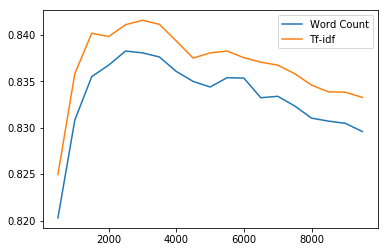

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(possible_n, cnt_accuracies, label='Word Count')
plt.plot(possible_n, tfidf_accuracies, label='Tf-idf')
plt.legend()

### Save model

In [68]:
best = train_with_n_topwords(3000, tfidf=True) # best = (acc, model, vec)

In [69]:
import pickle

# Save vectorizer
with open('tf_vec.pkl', 'wb') as pkl_file:
    pickle.dump(best[2], pkl_file)

In [70]:
with open('mnb_model.pkl', 'wb') as pkl_file:
    pickle.dump(best[1], pkl_file)